# Importing necessary packages

In [1]:
import os
import pickle
from pathlib import Path

import numpy as np
import pandas as pd

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

import matplotlib.pyplot as plt
import seaborn as sns

from hyperopt import Trials, tpe, hp, fmin, space_eval
from hyperopt.pyll import scope

import shap

import warnings
# Ignore all future warnings in Jupyter notebook
warnings.filterwarnings('ignore', category=FutureWarning)

C:\Users\zeshan\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data importing and preperation

In [2]:
# import data
project_path=os.getcwd()
df1_path= os.path.join(project_path,"data/dataset1.csv")
df1 = pd.read_csv(df1_path)
df_type='dataset1'

# Data procesing and adding important concrete ratio
df1.columns=['Cem', 'BFS','FA', 'Water','SP','CAg', 'FAg', 'Age','CS']

df1['W/B'] = df1['Water']/(df1['Cem'] + df1['BFS'] + df1['FA'])
df1['BFS/W'] = df1['BFS']/df1['Water']
df1['FA/W'] = df1['FA']/df1['Water']
df1['CAg/B'] = df1['CAg']/(df1['Cem'] + df1['BFS'] + df1['FA'])
df1['CAg/FAg'] = df1['CAg']/df1['FAg']

cs_column = df1.pop('CS')  
df1['CS'] = cs_column 

plt.figure(figsize=(12, 5))
df1.describe().T.to_csv(f'results/{df_type}_statSumm.csv')
df1.describe()

,Cem,BFS,FA,Water,SP,CAg,FAg,Age,W/B,BFS/W,FA/W,CAg/B,CAg/FAg,CS
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,0.469233,0.406854,0.313417,2.520997,1.273752,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,0.127123,0.471962,0.375626,0.679711,0.185670,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,0.235073,0.000000,0.000000,1.284375,0.858453,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,0.383916,0.000000,0.000000,1.950417,1.121488,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,0.471974,0.127389,0.000000,2.480550,1.266055,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,0.561081,0.796875,0.633053,3.000000,1.358146,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,0.900000,1.935380,1.344828,5.625000,1.874876,82.600000


<Figure size 1200x500 with 0 Axes>

## Getting the correlation of featrues

In [3]:
df1_corr = df1.copy()
df1_corr = df1_corr.corr().round(4)
df1_corr.to_csv(f'data/{df_type}_corrSummary.csv')
df1_corr

,Cem,BFS,FA,Water,SP,CAg,FAg,Age,W/B,BFS/W,FA/W,CAg/B,CAg/FAg,CS
Cem,1.0000,-0.2752,-0.3975,-0.0816,0.0924,-0.1093,-0.2227,0.0819,-0.4750,-0.2355,-0.3902,-0.4851,0.1442,0.4978
BFS,-0.2752,1.0000,-0.3236,0.1073,0.0433,-0.2840,-0.2816,-0.0442,-0.2791,0.9892,-0.3366,-0.4149,0.0544,0.1348
FA,-0.3975,-0.3236,1.0000,-0.2570,0.3775,-0.0100,0.0791,-0.1544,-0.1358,-0.3243,0.9888,-0.0016,-0.0995,-0.1058
Water,-0.0816,0.1073,-0.2570,1.0000,-0.6575,-0.1823,-0.4507,0.2776,0.5313,0.0024,-0.3392,0.0701,0.2293,-0.2896
SP,0.0924,0.0433,0.3775,-0.6575,1.0000,-0.2660,0.2227,-0.1927,-0.5999,0.1239,0.3892,-0.4061,-0.3024,0.3661
CAg,-0.1093,-0.2840,-0.0100,-0.1823,-0.2660,1.0000,-0.1785,-0.0030,0.2250,-0.2761,0.0433,0.5988,0.6709,-0.1649
FAg,-0.2227,-0.2816,0.0791,-0.4507,0.2227,-0.1785,1.0000,-0.1561,0.2460,-0.2338,0.1075,0.3654,-0.8359,-0.1672
Age,0.0819,-0.0442,-0.1544,0.2776,-0.1927,-0.0030,-0.1561,1.0000,0.1499,-0.0688,-0.1483,0.0280,0.1316,0.3289
W/B,-0.4750,-0.2791,-0.1358,0.5313,-0.5999,0.2250,0.2460,0.1499,1.0000,-0.3425,-0.1618,0.8441,-0.0728,-0.6231
BFS/W,-0.2355,0.9892,-0.3243,0.0024,0.1239,-0.2761,-0.2338,-0.0688,-0.3425,1.0000,-0.3323,-0.4364,0.0248,0.1821


## Data partitioning into training, validation and testing datasets

In [4]:
Input_features = df1.columns.drop(['CS'])
print(Input_features)
X = df1[Input_features]
y = df1['CS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=2)
X_train_wo_valid, X_val, y_train_wo_valid, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=2)

Index(['Cem', 'BFS', 'FA', 'Water', 'SP', 'CAg', 'FAg', 'Age', 'W/B', 'BFS/W',
       'FA/W', 'CAg/B', 'CAg/FAg'],
      dtype='object')


# TPE optimization of xgboost

In [5]:
def objFun(params):
        model = XGBRegressor(**params, random_state=np.random.RandomState(11), n_jobs=-1)
        model.fit(X_train_wo_valid, y_train_wo_valid)    
        predict_val = model.predict(X_val)
        rmse = root_mean_squared_error(y_val, predict_val)
        return rmse

space={'n_estimators': scope.int(hp.quniform('n_estimators', 50, 10000,1)),
        'min_split_loss': scope.float(hp.uniform('min_split_loss', 0.0001, 1.0)),
            'max_depth': scope.int(hp.quniform('max_depth', 2, 7,1)),
            'subsample': scope.float(hp.uniform('subsample', 0.9, 1)),
            'reg_alpha': scope.float(hp.uniform('reg_alpha', 0.01, 1.0)),
            'grow_policy': hp.choice('grow_policy', ['depthwise', 'lossguide']),
            'learning_rate': scope.float(hp.uniform('learning_rate', 0.01, 0.20)),
            'colsample_bylevel': scope.float(hp.uniform('colsample_bylevel', 0.9, 1)),
            'colsample_bytree': scope.float(hp.uniform('colsample_bytree', 0.9, 1)),
        }

trials = Trials()
rng = np.random.default_rng(11)
best = fmin(fn=objFun,
            space=space,
            algo=tpe.suggest,
            max_evals=500,
            trials=trials,
            rstate=rng)
xgb_best=best
best_hyperparams =  space_eval(space, xgb_best)   
best_hyperparams.update({'RMSE': trials.best_trial['result']['loss']})
pd.DataFrame.from_dict([best_hyperparams]).to_csv(f'results/{df_type}_best_hyperparams.csv', index=False)

100%|██████████| 500/500 [25:58<00:00,  3.12s/trial, best loss: 3.351444903335277] 


In [6]:
with open( f'results/{df_type}_xgb_traisl.pkl', 'wb') as file:
    pickle.dump(trials, file)
with open(f'results/{df_type}_xgb_best.pkl', 'wb') as file:
    pickle.dump(best, file)

## Comparison with other ML methods

In [7]:
model_list = ['TPE_xgboost','xboost_naïve','RF', 'SVM','ANN']
res_dic = {}
for idx, model_name in enumerate(model_list):
    if model_name == 'TPE_xgboost':
        df_best_hyperparams=pd.read_csv(f'results/{df_type}_best_hyperparams.csv')
        model = XGBRegressor(n_estimators=df_best_hyperparams['n_estimators'].values[0],
                            max_depth=df_best_hyperparams['max_depth'].values[0],
                            min_split_loss=df_best_hyperparams['min_split_loss'].values[0],
                            reg_alpha=df_best_hyperparams['reg_alpha'].values[0],
                            grow_policy=df_best_hyperparams['grow_policy'].values[0],
                            colsample_bylevel=df_best_hyperparams['colsample_bylevel'].values[0],
                            colsample_bytree=df_best_hyperparams['colsample_bytree'].values[0],
                            learning_rate=df_best_hyperparams['learning_rate'].values[0],
                            subsample=df_best_hyperparams['subsample'].values[0],
                            random_state=11,
                            n_jobs=-1)
        model.fit(X_train, y_train)
        xgb_opt_path = f'results/{df_type}_xgb_opt.pkl'
        with open(xgb_opt_path, 'wb') as file:
            pickle.dump(model, file)
    elif model_name == 'xboost_naïve':
        model =  XGBRegressor(random_state=8)
        model.fit(X_train, y_train)
    elif model_name == 'RF':
        model = RandomForestRegressor(random_state=8)
        model.fit(X_train, y_train)
    elif model_name == 'SVM':
        model =  SVR(kernel='rbf')
        model.fit(X_train, y_train)
    elif model_name == 'ANN':
        model = MLPRegressor(random_state=8)
        model.fit(X_train, y_train)
    predictions_train = model.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))
    r2_train = r2_score(y_train, predictions_train)
    mae_train = mean_absolute_error(y_train, predictions_train)
    predictions_val = model.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, predictions_val))
    r2_val = r2_score(y_val, predictions_val)
    mae_val = mean_absolute_error(y_val, predictions_val)
    predictions_test = model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))
    r2_test = r2_score(y_test, predictions_test)
    mae_test = mean_absolute_error(y_test, predictions_test)
    res_dic[f'{model_name}'] = {'RMSE_training': rmse_train,
                                'RMSE_validation': rmse_val,
                                'RMSE_testing': rmse_test,
                                'R2_training': r2_train,
                                'R2_validation': r2_val,
                                'R2_testing': r2_test,
                                'MAE_training': mae_train,
                                'MAE_validation': mae_val,
                                'MAE_testing': mae_test}
results_df=pd.DataFrame.from_dict(res_dic)
results_df

C:\Users\zeshan\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,TPE_xgboost,xboost_naïve,RF,SVM,ANN
RMSE_training,1.677958,1.214398,1.934349,14.761620,7.161189
RMSE_validation,1.143687,0.565482,1.612443,14.887014,6.968616
RMSE_testing,2.552801,3.162684,3.740464,13.131025,6.656673
R2_training,0.990113,0.994821,0.986860,0.234776,0.819909
R2_validation,0.995545,0.998911,0.991145,0.245230,0.834616
R2_testing,0.970485,0.954697,0.936633,0.219075,0.799310
MAE_training,0.977952,0.471247,1.203574,11.792731,5.318894
MAE_validation,0.839786,0.384241,1.179247,12.102267,5.208740
MAE_testing,1.812135,1.928856,2.760947,10.466153,5.016374


In [8]:
results_df.to_csv(f'results/{df_type}results.csv')

## Ploting optimizaiton resusts

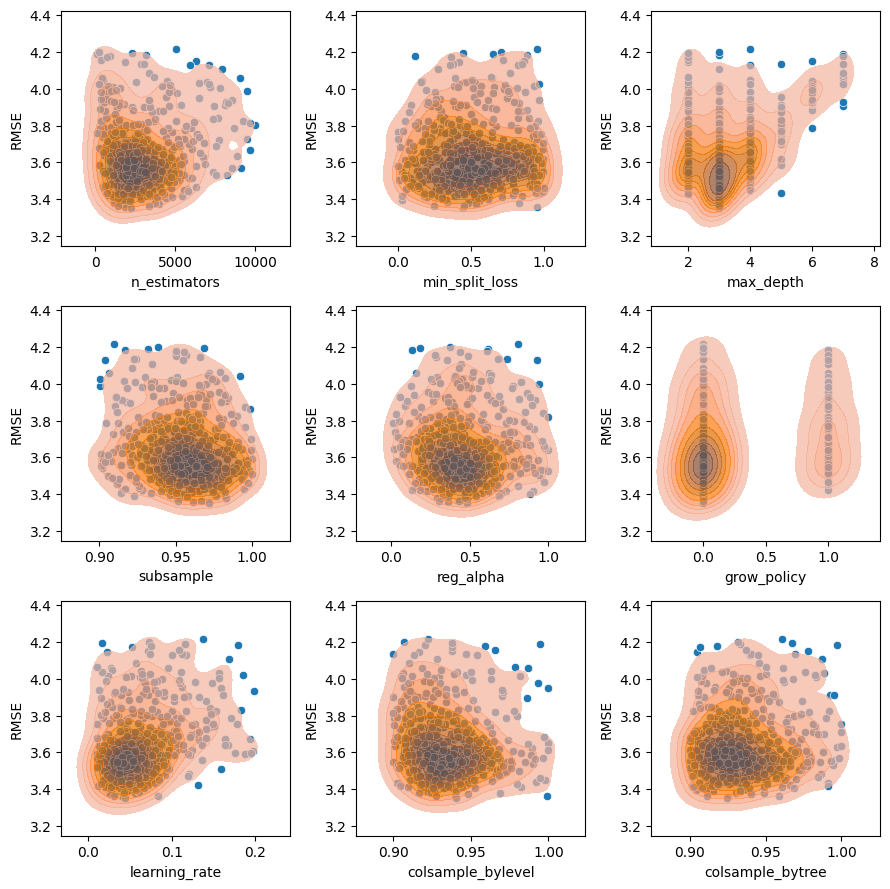

In [9]:
with open( f'results/{df_type}_xgb_traisl.pkl', 'rb') as file:
    trials = pickle.load(file)
with open(f'results/{df_type}_xgb_best.pkl', 'rb') as file:
    xgb_best = pickle.load(file)
    

losses = [trial['result']['loss'] for trial in trials.trials]
q3 = np.percentile(losses, 75)
upper_bound = q3 + 1.5 * (q3 - np.percentile(losses, 25))
filtered_trials = [trial for trial in trials.trials if trial['result']['loss'] <= upper_bound]

df_trials = pd.DataFrame([{**{k: v[0] for k, v in trial['misc']['vals'].items()}, 'loss': trial['result']['loss']} for trial in filtered_trials])
hyperparameters = ['n_estimators', 'min_split_loss', 'max_depth', 'subsample', 'reg_alpha', 'grow_policy',
                   'learning_rate', 'colsample_bylevel', 'colsample_bytree']

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.flatten()
min_loss_index = df_trials['loss'].idxmin()
for i, hyperparam in enumerate(hyperparameters):
    ax = axes[i]
    sns.scatterplot(x=hyperparam, y='loss', data=df_trials, ax=ax)
    sns.kdeplot(y='loss',data=df_trials, x=hyperparam, ax=ax, fill=True, alpha=.7)
    ax.set_xlabel(hyperparam)
    ax.set_ylabel('RMSE')
    best_hyperparam_value = df_trials.loc[min_loss_index, hyperparam]
    best_loss = df_trials.loc[min_loss_index, 'loss']

plt.tight_layout()
plt.savefig(f'results/{df_type}_trailsvsloss.svg', format='svg')
plt.savefig(f'results/{df_type}_trailsvsloss.png', format='png')
plt.show()
plt.close()

In [10]:
# Load the saved model
with open(xgb_opt_path, 'rb') as file:
    model = pickle.load(file)

## Plotting the diagnostic curves

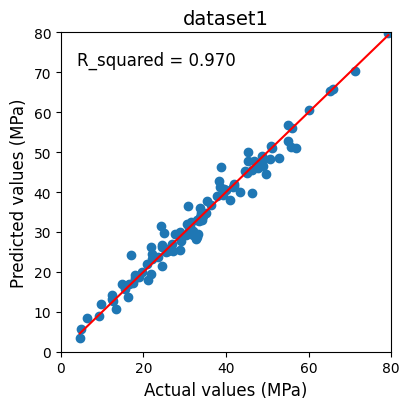

In [11]:
plt.figure(figsize=(4.2, 4.2))
plt.scatter(y_test, model.predict(X_test))
plt.xlabel('Actual values (MPa)', fontsize=12)
plt.ylabel('Predicted values (MPa)', fontsize=12)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.annotate(f"R_squared = {results_df['TPE_xgboost']['R2_testing']:.3f}", xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12)
plt.title('dataset1', fontsize=14)
plt.ylim([0, 80])  # Set the y-axis limits to -10 and 10
plt.xlim([0, 80]) 
plt.tight_layout()

plt.savefig(f'results/{df_type}_predvsact.svg', format='svg',dpi=600)
plt.savefig(f'results/{df_type}_predvsact.png', format='png',dpi=600)
plt.show()

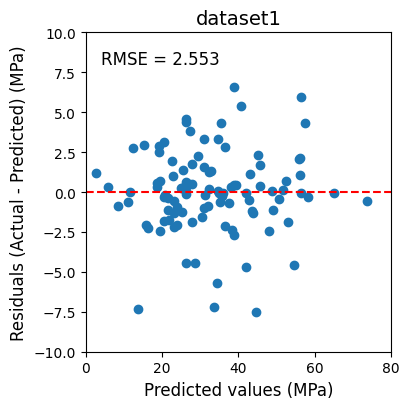

In [12]:
plt.figure(figsize=(4.2, 4.2))
residuals = y_test - model.predict(X_test)
plt.scatter(predictions_test, residuals)
plt.xlabel('Predicted values (MPa)', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted) (MPa)', fontsize=12)
plt.axhline(y=0, color='red', linestyle='--')
plt.annotate(f"RMSE = {results_df['TPE_xgboost']['RMSE_testing']:.3f}", xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12)
plt.title('dataset1', fontsize=14)
plt.ylim([-10, 10])  # Set the y-axis limits to -10 and 10
plt.xlim([0, 80]) 
plt.tight_layout()

plt.savefig(f'results/{df_type}_residualvspred.svg', format='svg', dpi=600)
plt.savefig(f'results/{df_type}_residualvspred.png', format='png',dpi=600)
plt.show()
plt.close()

# Explainability analyses and results

In [13]:
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9406943472620554, colsample_bynode=None,
             colsample_bytree=0.9245431921467372, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy='depthwise',
             importance_type=None, interaction_constraints=None,
             learning_rate=0.0441532062834216, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, min_split_loss=0.4487855204389156,
             missing=nan, monotone_constraints=None, n_estimators=2204,
             n_jobs=-1, num_parallel_tree=None, predictor=None, ...)

In [14]:
df_exp = X_test[X_test.columns]
explainer = shap.TreeExplainer(model)
shap_values = explainer(df_exp)

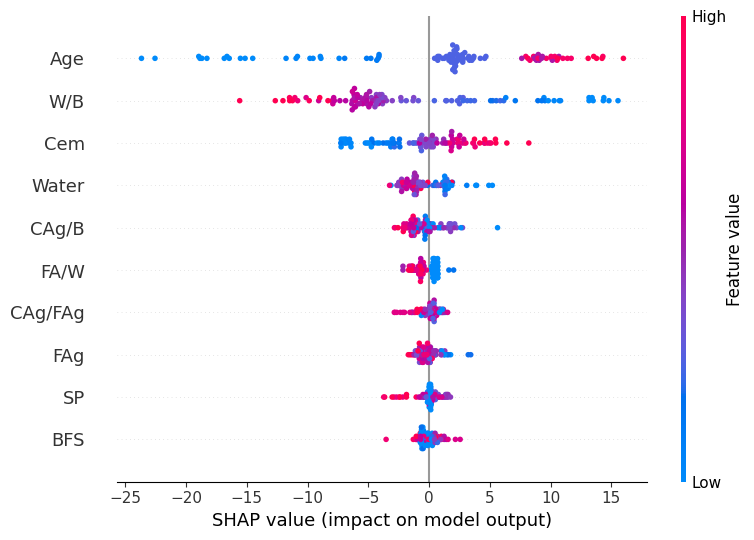

In [15]:
%matplotlib inline 
plt.figure()
shap.summary_plot(shap_values, df_exp, feature_names=df_exp.columns, max_display=10, show=False)
plt.savefig(f'results/{df_type}_shapfeatimp.svg', format='svg', dpi=600, bbox_inches='tight')
plt.savefig(f'results/{df_type}_shapfeatimp.png', format='png', dpi=600, bbox_inches='tight')
plt.show()  
plt.close()

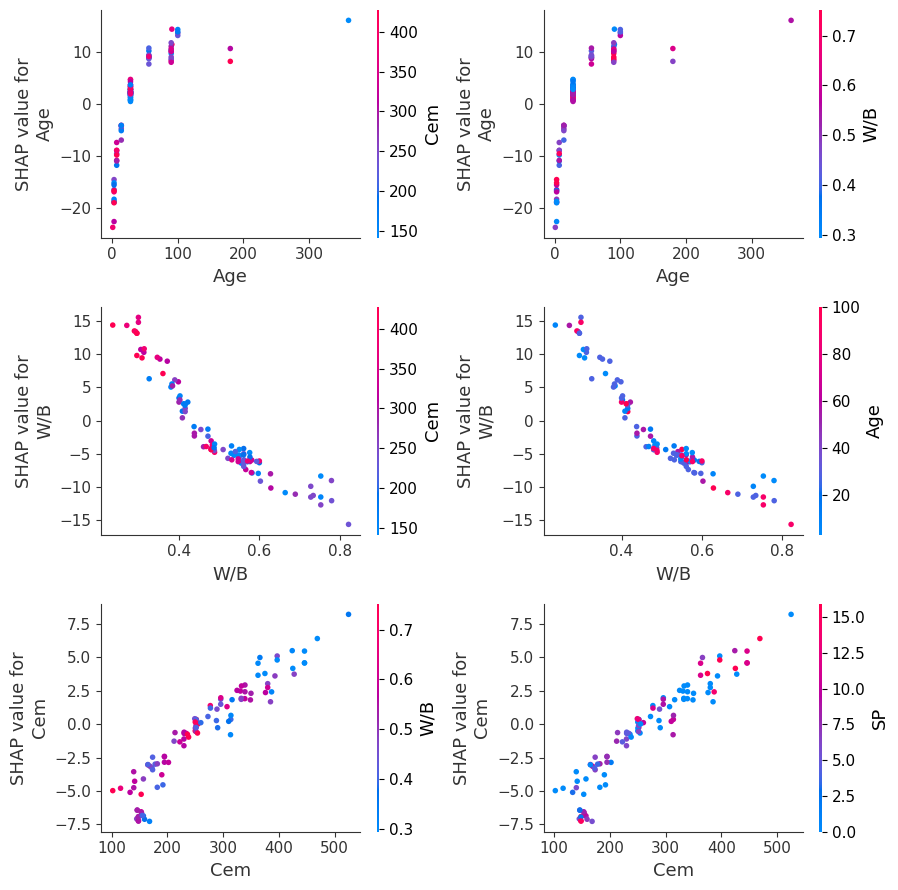

In [18]:
%matplotlib inline 
shap_values = explainer.shap_values(X_test[X_test.columns])
top_3_features= ["Age","W/B","Cem"]
fig, axes = plt.subplots(len(top_3_features), 2, figsize=(9, 9))
for feat_level, feat in enumerate(top_3_features):
    # print(f'{feat_level}:{feat}')
    inds = shap.approximate_interactions(feat, shap_values, df_exp)
    # print(inds)
    # shap.dependence_plot(feat, shap_values, X_test, interaction_index=inds[i])
    for i in range(2):
        ax = axes[feat_level, i]
        # plt.subplot(len(top_3_features), 2, feat_level * 2 + (i + 1))  # Specify subplot position
        shap.dependence_plot(feat, shap_values, X_test, interaction_index=inds[i], ax=ax, show=False) 
        # shap.dependence_plot(feat, shap_values, X_test, interaction_index=inds[i],ax=ax)
plt.tight_layout()
plt.savefig(f'results/{df_type}_all_interactions.svg', format='svg', dpi=600, bbox_inches='tight')
plt.show()
plt.close()